In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import brentq, minimize

import copy as copy
from enum import Enum

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
np.random.seed(90)

In [3]:
# calibrated hazard rates
lam = 0.051
lam_LTC = 0.034
lam_min = 0.01
o_hat = 0.064
scale = (lam - lam_min) * np.exp(-0.5 * o_hat**2)

# calibrated investment returns
u_M = 0.095
r = 0.005
pi = 0.025
o_pi = 0.0185
o_M = 0.16

# calibrated loadings
S = 0.2

# calibrated consumption rates
c_dct = {'Bengen 4% Rule': 0.040, 'Modest SOL': 0.052, 'Comfortable SOL': 0.082}
c_set = list(c_dct.values()); titles = list(c_dct.keys())

# choice of threshold level
v_set = [0, 0.2]
psi_max = 0.3
b_max = 3

In [4]:
# search resolution
phi_step = 750
w_step = 750
psi_step = 40
b_step = 40

# simulation sizes
lam_sims = 200
pool_sims = 500
pol_num = 5000

# parameters of search for tau
max_ruin_time = 80 # max value of tau
search_period = 10 # partition to search for minimum root

In [5]:
# decumulation strategies
class strat(Enum):
    Pure_Drawdown = 0
    IIA = 1  
    ULA = 2
    GSA = 3  
    LIA = 4

# strategies with loadings
valid_load_set = [strat.IIA, strat.ULA]

In [6]:
# simulate pooled hazard rate and pooled lifetime
lam_rand = lam_min + scale * np.exp(o_hat * np.random.normal(size=lam_sims))

In [7]:
def u(w): 
    '''Returns the trend rate of real returns as function of market weight'''
    return (1 - w) * (r + pi) + w * u_M - pi

def o(w):
    '''Returns the volatility of real returns as function of market weight'''
    return w * np.sqrt(o_M**2 + o_pi**2)

def a_x(w):
    '''Returns the expected annuity present value as function of market weight'''
    return 1 / (lam + u(w) - o(w)**2) 

def a(w, T, dev=0): 
    '''Returns the expected insurance present value as function of market weight'''
    return (1 -  np.exp(-(dev + u(w)) * T )) / (dev + u(w))

def th(w): 
    '''Returns the loading as a function of the market weight'''
    def pool_moms(lam_): 
        '''Returns the moments of the present value annuity random variable for random hazard rate'''
        ann_sims = np.zeros((pol_num, pool_sims))
        for pool_sim in range(pool_sims):
            ann_sims[:,pool_sim] = a(w, np.random.exponential(scale=1/lam_, size=pol_num))  
        return np.var(ann_sims, axis=0).mean(), np.mean(ann_sims)    
    
    cost_dist = list(map(pool_moms, lam_rand))
    cost_var, cost_mean = zip(*cost_dist)
    cond_std = np.sqrt(np.var(cost_mean) + np.mean(cost_var)) # conditional variance
    
    return S * cond_std / a_x(w) # backsolve loading from Sharpe Ratio

In [8]:
def shape(w):
    '''Returns shape parameter of inverse gamma distribution'''
    return (2 * (u(w) + lam) / o(w)**2 - 1) - 2
w_1 = brentq(shape, a=1, b=20)

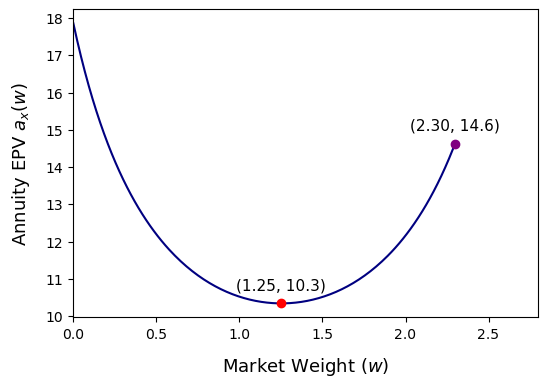

In [9]:
w_seq = np.linspace(0, w_1, 200)
fig = plt.figure(figsize=(6, 4))
plt.plot(w_seq, list(map(a_x, w_seq)), color = 'navy')
optim = minimize(a_x, 1)
plt.xlim(0, 2.8)
plt.plot(optim.x, optim.fun, '-ro')
plt.annotate(f"({float(optim.x[0]):.2f}, {float(optim.fun):.1f})",
             (optim.x, optim.fun), textcoords="offset points", 
             xytext=(0,10), ha='center', fontsize=11)
plt.plot(w_1, a_x(w_1), '-o', color='purple')
plt.annotate(f"({w_1:.2f}, {a_x(w_1):.1f})",
             (w_1, a_x(w_1)), textcoords="offset points", 
             xytext=(0,10), ha='center', fontsize=11)

plt.ylabel('Annuity EPV ' + r'$a_x(w)$', fontsize=13, labelpad=10)
plt.xlabel('Market Weight $(w)$', fontsize=13, labelpad=10)
plt.savefig('annuity_epv.png', dpi=400, bbox_inches="tight")
w_max = minimize(a_x, 1).x # ceiling on market weight

In [10]:
def ruin_prob(w, phi, strat_, c, the=0, v=0):
    '''Returns the ruin probability in the D information set'''
         
    def prob_calc(lam_):
        '''Returns the ruin probability conditional on random hazard rate'''  
        
        def VD(t):
            '''Returns V in the D information set as a function of t'''
            base = 1 - v - c * a(w, t)
            if strat_ == strat.IIA:
                return base + phi * (a(w, t) - a_x(0) * (1 + the))
            if strat_ == strat.ULA:
                return base + phi * (a(w, t) - a_x(w) * (1 + the))
            if strat_ == strat.GSA:
                return base + phi * (a(w, t, lam - lam_) - a_x(w))
            if strat_ == strat.LIA:
                return base + phi * (a(w, t, lam - lam_) - a_x(0)) 

        tau = None
        if VD(0) < 0: # if initially in debt then immediate ruin occurs
            tau = 0          
        
        elif strat_ in [strat.GSA, strat.LIA]: # check for multiple roots for GSA and LIA 
            search_bound = np.linspace(0, max_ruin_time, search_period)
            for i in range(search_period):
                try: 
                    time = brentq(VD, a=search_bound[i], b=search_bound[i+1])
                    tau = time
                    break # ruin time will be first solution
                except: # let the ruin time be infinite when there is no root
                    tau = np.infty
        else: # do not need to check for multiple roots for IIA and ULA
            try:
                tau = brentq(VD, a=0, b=max_ruin_time)
            except:
                tau = np.infty
        
        return np.exp(-(lam_ + lam_LTC) * tau)   
    
    probs_rand = list(map(prob_calc, lam_rand))
    return np.mean(probs_rand)

In [11]:
def mean_var(w, phi, strat_, c, the=0):
    '''Returns the mean and variance of V in in the I information set'''

    # compute the moments of the inverse gamma distribution
    if w != 0:
        alpha = 2 * (u(w) + lam) / o(w)**2 - 1
        beta = 2 / o(w)**2
        base_mean = beta / (alpha - 1)
        sqr_mom = beta**2 / ((alpha - 1) * (alpha - 2))
        base_var = sqr_mom - base_mean**2
    else:
        base_mean = a_x(0)
        base_var = 0

    # compute the moments of the entire V_I expression
    base = 1 - c * base_mean
    if strat_ == strat.IIA:
        VI_mean = base + phi * (base_mean - a_x(0) * (1 + the))
        VI_var = (c - phi)**2 * base_var
    if strat_ == strat.ULA:
        VI_mean = base + phi * (a_x(w) - a_x(w) * (1 + the))
        VI_var = c**2 * base_var
    if strat_ == strat.GSA: 
        VI_mean = base
        VI_var = c**2 * base_var
    if strat_ == strat.LIA:
        VI_mean = base + phi * (base_mean - a_x(0))
        VI_var = (c - phi)**2 * base_var
    return VI_mean, VI_var

In [12]:
class info_ret:
    def __init__(self, strat_, c, v):
        '''Extracts a grid of mean, variance and ruin probability for varying (w, phi)'''    
        # compute the loadings depending on the strategy
        the_ = 0
        self.w_range = np.linspace(0, w_max, w_step)
        if strat_ == strat.IIA:
            the_ = th(0)
        if strat_ == strat.ULA:
            the_ = list(map(th, self.w_range))
    
        # extract means and variances
        def mean_var_ret(w, phi, the):
            return mean_var(w, phi, strat_, c, the)
        mean_var_ret_vec = np.vectorize(mean_var_ret)
    
        # extract ruin probabilities
        def ruin_prob_ret(w, phi, the):
            return ruin_prob(w, phi, strat_, c, the, v)
        ruin_prob_ret_vec = np.vectorize(ruin_prob_ret)
    
        empty =  np.full((phi_step, phi_step), np.nan)
        self.probs, self.means, self.var = copy.deepcopy(empty), copy.deepcopy(empty), copy.deepcopy(empty)
        self.phi_range = np.linspace(0, c, phi_step)
    
        for j in range(w_step):    
            w_j = j * w_max/w_step
            the_j = the_
            if strat_ == strat.ULA:
                the_j = the_[j]
            self.means[:, j], self.var[:, j] = mean_var_ret_vec(w_j, self.phi_range, the_j)
            self.probs[:, j] = ruin_prob_ret_vec(w_j, self.phi_range, the_j)

In [13]:
# extracts a grid of mean, variance and ruin probability for varying (w, phi) and c
strat_info_ret_v0 = []
for j in list(strat)[1:]:
    strat_info_ret_j = []    
    for i in range(len(c_set)):
        strat_info_ret_j.append(info_ret(strat(j), c_set[i], v_set[0]))
    strat_info_ret_v0.append(strat_info_ret_j)

strat_info_ret_v1 = []
for j in list(strat)[1:]:
    strat_info_ret_j = []    
    for i in range(len(c_set)):
        strat_info_ret_j.append(info_ret(strat(j), c_set[i], v_set[1]))
    strat_info_ret_v1.append(strat_info_ret_j)

In [14]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

color_list = {0: 'purple', 1: 'green', 2: 'blue', 3: 'red', 4: 'orange'}
handles = [mpatches.Patch(color=color_list[i], label=strat(i).name.replace("_", " ")) for i in color_list]

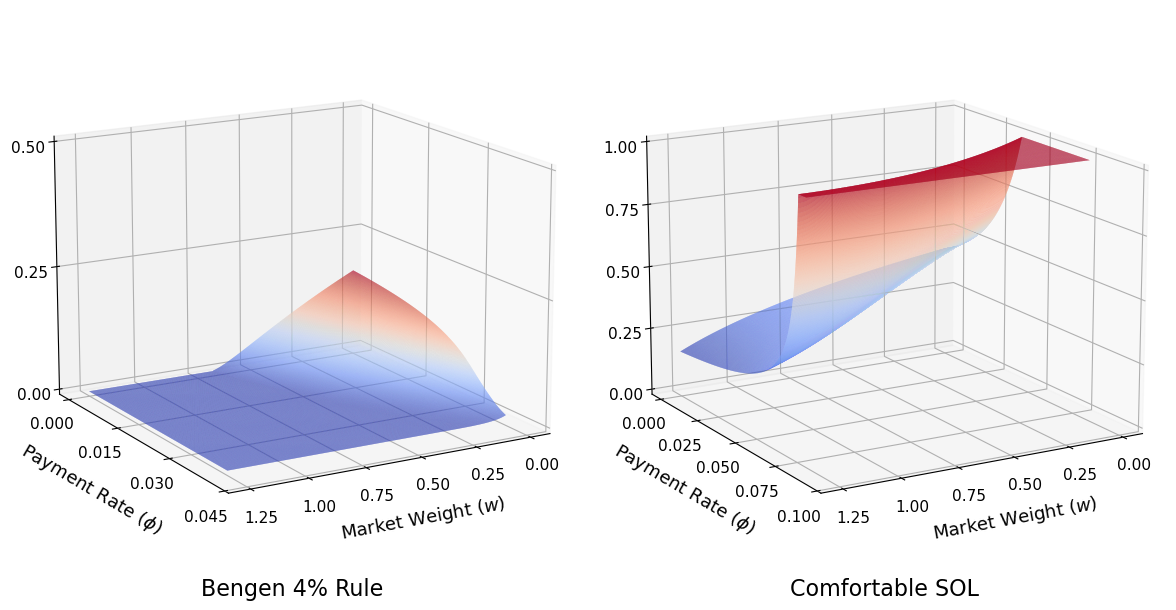

In [15]:
def plot_shortfall(strat_info):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')
    for i in [0, 2]:
        j = min(i, 1)
        y_ = copy.deepcopy(strat_info[i].phi_range)
        x_ = copy.deepcopy(strat_info[i].w_range)
        (x, y) = np.meshgrid(x_, y_)
        z = copy.deepcopy(strat_info[i].probs)
        
        ax[j].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)
        ax[j].view_init(elev=15, azim=-300)

        ax[j].set_ylabel('Payment Rate ' + r'$(\phi)$', fontsize=13, labelpad=10)
        ax[j].set_xlabel('Market Weight ' + r'$(w)$', fontsize=13, labelpad=10)
        ax[j].set_title(f'{list(c_dct.keys())[i]}', fontsize=16, y=-0.01, pad=-12)
        ax[j].xaxis.set_tick_params(labelsize=11)
        ax[j].yaxis.set_tick_params(labelsize=11)
        ax[j].zaxis.set_tick_params(labelsize=11)
        ax[j].set_xticks(np.arange(0, 1.5, 0.25))
        ax[j].set_zticks(np.arange(0, 1.25, 0.25))
    ax[0].set_yticks(np.arange(0, 0.06, 0.015))
    ax[1].set_yticks(np.arange(0, 0.125, 0.025))
    ax[0].set_zlim(0, 0.5)
    ax[1].set_zlim(0, 1.0)

    fig.tight_layout()
    plt.savefig('plot_shortfall.png', dpi=400, bbox_inches="tight")
    plt.show()
    plt.close()

plot_shortfall(strat_info_ret_v1[2])

In [16]:
class opt_set_ret:
    def __init__(self, info_):
        '''Extracts the optimal (w, phi) for ALL (psi, b)'''
        psi_set = np.linspace(0, psi_max, psi_step)
        b_set = np.linspace(0, b_max, b_step)
        empty =  np.full((psi_step, b_step), np.nan)
        self.weights, self.utils, self.rates = copy.deepcopy(empty), copy.deepcopy(empty), copy.deepcopy(empty)

        def opt_ret(psi, b, info_):
            '''Extracts the optimal (w, phi) for EACH (psi, b)'''
            max_utils = -np.infty
            opt_w, opt_phi = np.nan, np.nan
            for j in range(w_step):
                for i in range(phi_step):
                    utils = info_.means[i, j] - b * (info_.var[i, j] + info_.means[i, j]**2)
                    if info_.probs[i, j] <= psi and utils > max_utils:
                        max_utils = utils # update optimum if constraint is satisfied but utility is higher
                        opt_w, opt_phi = info_.w_range[j], info_.phi_range[i]
            if max_utils == -np.infty:
               max_utils = np.nan
            return opt_w, opt_phi, max_utils
        
        for i in range(psi_step):
            for j in range(b_step):
                self.weights[i, j], self.rates[i, j], self.utils[i, j] = opt_ret(psi_set[i], b_set[j], info_)

In [17]:
class strat_picker:
    def __init__(self, c_idx, info_set):
        '''
        Finds the optimal strategy across g(.) and (w, phi) for each (psi, b)
        ''' 
        psi_set = np.linspace(0, psi_max, psi_step)
        b_set = np.linspace(0, b_max, b_step)

        opt_set_strats = [] # create a list of optimal strategies
        for i in range(len(strat) - 1):
            opt_set_strats.append(opt_set_ret(info_set[i][c_idx]))


        empty = np.full((psi_step, b_step), np.nan)
        self.rates, self.weights, self.utils = copy.deepcopy(empty), copy.deepcopy(empty), copy.deepcopy(empty)
        self.ratio, self.opt_strat = copy.deepcopy(empty), copy.deepcopy(empty)

        for i in range(psi_step):
             for j in range(b_step):
                 opt_util_set = [opt_strat.utils[i, j] for opt_strat in opt_set_strats]
                 if not np.isnan(np.nanmax(opt_util_set)):
                     opt_arg = np.nanargmax(opt_util_set)
                     self.rates[i, j] = opt_set_strats[opt_arg].rates[i, j]
                     self.weights[i, j] = opt_set_strats[opt_arg].weights[i, j]
                     self.utils[i, j] = opt_set_strats[opt_arg].utils[i, j]
                     if opt_arg >= len(strat) - 1:
                         self.ratio[i, j] = opt_set_strats[opt_arg].ratio[i, j]
                             
                     if self.rates[i, j] == 0: # if phi = 0, then we obtain pure drawdown strategy                     
                         self.opt_strat[i, j] = strat.Pure_Drawdown.value
                     else:
                         self.opt_strat[i, j] = opt_arg + 1
                         
                     if strat(self.opt_strat[i, j]) == strat.ULA and self.weights[i, j] == 0:
                         self.opt_strat[i, j] = strat.IIA.value # a ULA is the IIA when w = 0
                     if strat(self.opt_strat[i, j]) == strat.GSA and self.weights[i, j] == 0:
                         self.opt_strat[i, j] = strat.LIA.value # a GSA is the LIA when w = 0

In [18]:
# collect optimal overall strategies with death benefit not allowed for all c
import warnings
warnings.filterwarnings('ignore')

picked_strats_v0 = []
for i in range(len(c_set)):
    picked_strats_v0.append(strat_picker(i, strat_info_ret_v0))

picked_strats_v1 = []
for i in range(len(c_set)):
    picked_strats_v1.append(strat_picker(i, strat_info_ret_v1))

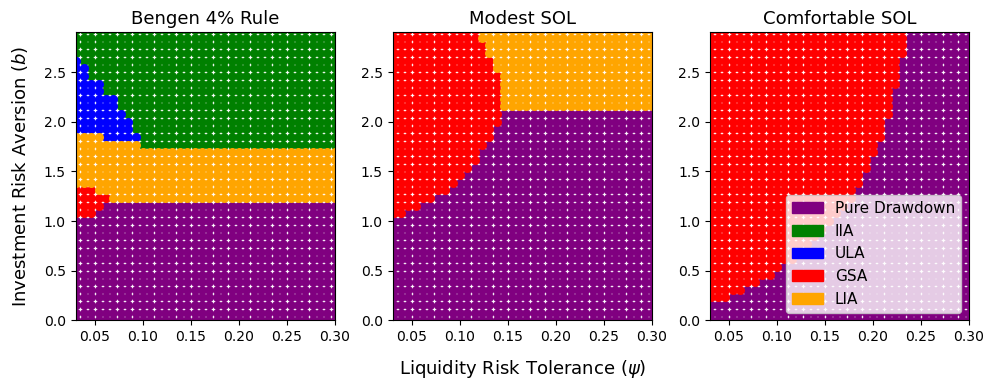

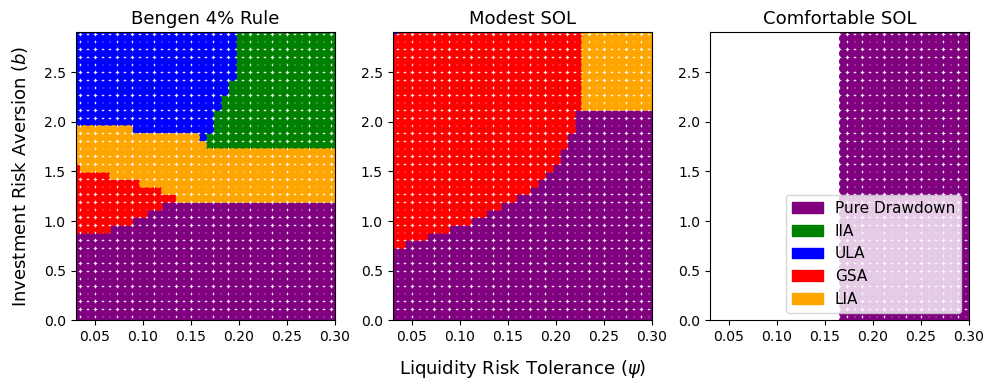

In [19]:
def decision_plot(strat_set, v=0):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.subplots(nrows=1, ncols=3)

    for j in range(len(c_set)):
        df = pd.DataFrame()
        df['Product'] = strat_set[j].opt_strat.flatten()
        df['Rates'] = strat_set[j].rates.flatten()
        df['LRT'] = np.linspace(0, psi_max, psi_step).repeat(b_step)
        df['IRA'] = np.tile(np.linspace(0, b_max, b_step), psi_step)
        df = df[(~df['Product'].isnull())].reset_index(drop = True)
        y, X = df['Product'], df.drop(columns = ['Product'])

        classes = np.unique(y)
        n_classes = len(np.unique(y))
        for i in range(n_classes):
            idx = np.where(y == classes[i])
            ax[j].scatter(X.loc[idx, 'LRT'], X.loc[idx, 'IRA'],
            c=color_list[classes[i]], label = strat(i).name, s = 30)
        ax[j].set_title(f'{titles[j]}', fontsize=13)
        ax[j].set_xlim(0.03, 0.3)
        ax[j].set_ylim(0, 2.9)
    
    ax[2].legend(handles=handles, loc = 'lower right', fancybox=True, fontsize=11)
    ax[1].set_xlabel('Liquidity Risk Tolerance ' + r'$(\psi)$', fontsize=13, labelpad=10)
    ax[0].set_ylabel('Investment Risk Aversion $(b)$', fontsize=13, labelpad=10)
    
    fig.tight_layout()
    plt.savefig(f'decision_plot_{v}' + '.png', dpi=400, bbox_inches="tight")
    plt.show()

decision_plot(picked_strats_v0, 0.0)
decision_plot(picked_strats_v1, 0.2)

In [20]:
def transformer(picked_strats, c_idx):
    data_2D = pd.DataFrame()
    data_2D['Product'] = picked_strats[c_idx].opt_strat.flatten()
    data_2D['Rates'] = picked_strats[c_idx].rates.flatten()
    data_2D['Weights'] = picked_strats[c_idx].weights.flatten()
    data_2D['LRT'] = np.linspace(0, psi_max, psi_step).repeat(b_step)
    data_2D['IRA'] = np.tile(np.linspace(0, b_max, b_step), psi_step)

    data_2D['Cost'] = copy.deepcopy(data_2D['Product'])
    data_2D['Market'] = copy.deepcopy(data_2D['Product'])


    for i in range(len(data_2D)):
        data_2D.loc[i, 'Cost'] = 0
        data_2D.loc[i, 'Market'] = data_2D.loc[i, 'Weights']
        if data_2D.loc[i, 'Product'] == strat.IIA.value:
            data_2D.loc[i, 'Cost'] = a_x(0) * (1 + th(0)) * data_2D.loc[i, 'Rates']
            data_2D.loc[i, 'Market'] = (1 - data_2D.loc[i, 'Cost']) * data_2D.loc[i, 'Weights']
        elif data_2D.loc[i, 'Product'] == strat.ULA.value:
            data_2D.loc[i, 'Cost'] = a_x(data_2D.loc[i, 'Weights']) * (1 + th(data_2D.loc[i, 'Weights'])) * data_2D.loc[i, 'Rates']
        elif data_2D.loc[i, 'Product'] == strat.GSA.value:
            data_2D.loc[i, 'Cost'] = a_x(data_2D.loc[i, 'Weights']) * data_2D.loc[i, 'Rates']
        elif data_2D.loc[i, 'Product'] == strat.LIA.value:
            data_2D.loc[i, 'Cost'] = a_x(0) * data_2D.loc[i, 'Rates']
            data_2D.loc[i, 'Market'] = (1 - data_2D.loc[i, 'Cost']) * data_2D.loc[i, 'Weights']
    return data_2D

In [21]:
trans_strats_bengen = transformer(picked_strats_v1, 0)
trans_strats_modest = transformer(picked_strats_v1, 1)

In [22]:
def pars_plot(df, psi, title):
    fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10, 4))    
    
    d1 = df.loc[(df['LRT'] == psi), 'Product']
    x1 = df.loc[(df['LRT'] == psi), 'Weights'].clip(0.02)
    x2 = df.loc[(df['LRT'] == psi), 'Rates'].clip(0.0005)
    y = df.loc[(df['LRT'] == psi), 'IRA']
            
    bar_0 = ax[0].barh(y, x1, align='center', color='gray', height=0.05)
    bar_1 = ax[1].barh(y, x2, align='center', color='gray', height=0.05)
    
    ax[0].set_xlim(0, 1.5)
    ax[0].invert_xaxis()
    ax[1].set_xlim(0, 0.05)
    ax[1].legend(handles=handles, loc = 'lower right', fancybox=True, fontsize=11)  
    ax[0].set_xlabel('Market Weight ' + r'$(w)$', fontsize=13, labelpad=10)
    ax[1].set_xlabel('Payment Rate ' + r'$(\phi)$', fontsize=13, labelpad=10)
    ax[0].set_ylabel('Investment Risk Aversion ' + r'$(b)$', fontsize=13, labelpad=10)
    
    for i, ax_ in enumerate(ax.flat):
        ax_.margins(0.02)
        ax_.grid(True)
        ax_.set_ylim(0, 2.9)
    
    for i in range(len(x1)):
        if not np.isnan(d1.iloc[i]):
            bar_0[i].set_color(color_list[d1.iloc[i]])
            bar_1[i].set_color(color_list[d1.iloc[i]])
    
    fig.tight_layout()
    plt.savefig(f'pars_plot_{title[0]}' + '.png', dpi=400, bbox_inches="tight")
    plt.show()

In [23]:
color_list_0 = {0: 'linen', 1: 'black'}
labels_0 = {0: 'Risk-free Asset', 1: 'Market Portfolio'}

color_list_1 = {0: 'lavenderblush', 1: 'green', 2: 'blue', 3: 'red', 4: 'orange'}
labels_1 = {i: strat(i).name for i in color_list_1}
labels_1[0] = 'Partial Drawdown'

def decum_plot(df, psi, title):
    
    opt_strat = df.loc[(df['LRT'] == psi), 'Product']
    market_alloc = df.loc[(df['LRT'] == psi), 'Market']
    rf_alloc = 1 - market_alloc
    prod_alloc = df.loc[(df['LRT'] == psi), 'Cost']
    drawdown_alloc = 1 - prod_alloc    
    y = df.loc[(df['LRT'] == psi), 'IRA']
    
    fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10, 4))
    
    ax[0].set_title('Wealth Allocated to Market', fontsize=13)
    ax[1].set_title('Wealth Allocated to Annuity Family', fontsize=13)
    
    bar_00 = ax[0].bar(y, market_alloc, align='center', color='black', width=0.05)
    bar_01 = ax[0].bar(y, rf_alloc, align='center', bottom=market_alloc, color='linen', width=0.05)

    bar_10 = ax[1].bar(y, prod_alloc, align='center', color='black', width=0.05)
    bar_11 = ax[1].bar(y, drawdown_alloc, align='center', bottom=prod_alloc, color='lavenderblush', width=0.05)

    for i in [0, 1]: 
        ax[i].set_yticks([0,0.25,0.5,0.75,1], ['0%','25%','50%','75%','100%'])
        ax[i].set_ylim(0, 1)
        ax[i].set_xlim(0.5, 2.9)
        ax[i].margins(0.01)
        ax[i].grid(True)

    for j in range(len(prod_alloc)):
        if not np.isnan(opt_strat.iloc[j]):
            bar_10[j].set_color(color_list[opt_strat.iloc[j]])
    
    fig.text(0.5, 0, '\nInvestment Risk Aversion ' + r'$(b)$', ha="center", va="center", fontsize=13)
    ax[0].set_ylabel('% Wealth Allocation', fontsize=13, labelpad=10)

    handles_0 = [mpatches.Patch(color=color_list_0[i], label=labels_0[i]) for i in color_list_0]
    ax[0].legend(handles=handles_0, loc = 'upper right', fancybox=True, fontsize=11)
    handles_1 = [mpatches.Patch(color=color_list_1[i], label=labels_1[i]) for i in color_list_1]
    ax[1].legend(handles=handles_1, loc = 'upper left', fancybox=True, fontsize=11)

    fig.tight_layout()
    plt.savefig(f'decum_plot_{title[0]}' + '.png', dpi=400, bbox_inches="tight")
    plt.show()

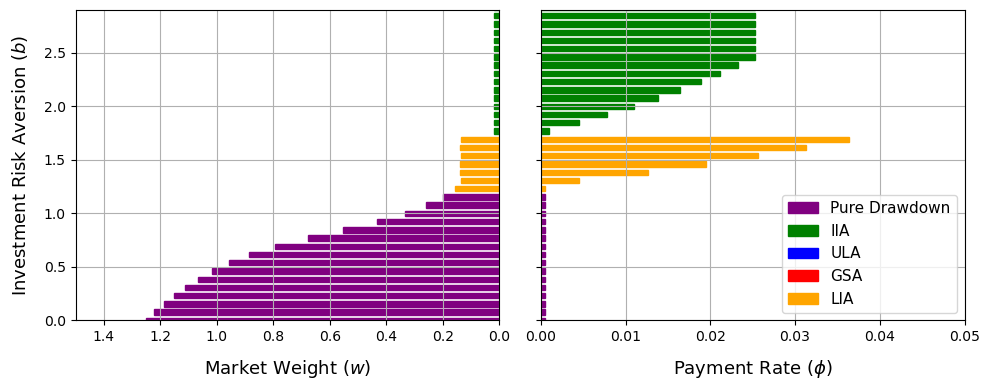

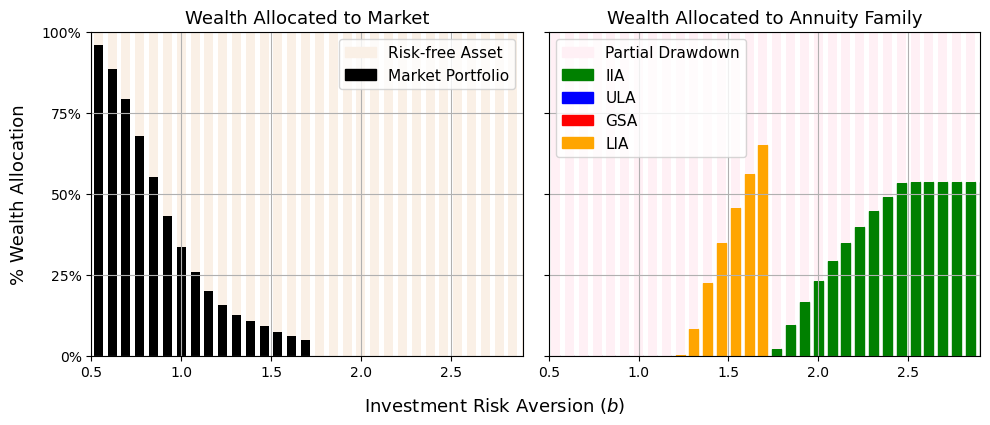

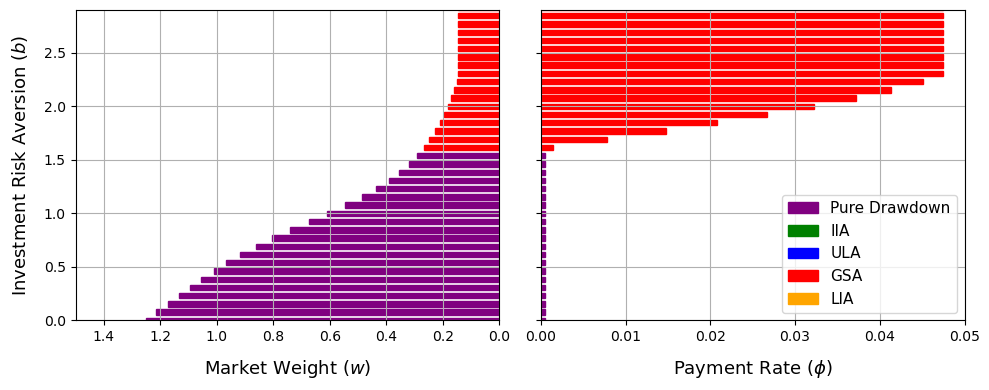

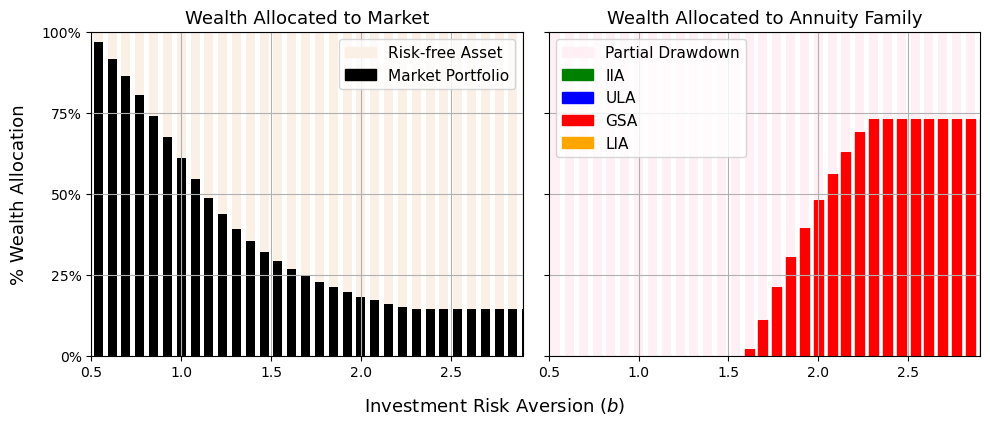

In [24]:
def find_closest_values(df, x):
    idx = (np.abs(df - x)).argmin()
    return df[idx]
    
def all_plots(trans, psi, title):
    psi_1 = find_closest_values(trans['LRT'], psi)
    pars_plot(trans, psi_1, title)
    decum_plot(trans, psi_1, title)

all_plots(trans_strats_bengen, 0.2, 'Bengen 4% Rule')
all_plots(trans_strats_modest, 0.2, 'Modest SOL')